# I/ General Zone

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
## Import neccessary packages
import pandas as pd
from csv import reader
import numpy as np
import squarify 

## Processing Text data packages
import nltk
import re
from nltk.corpus import stopwords
import spacy
from spacy.tokenizer import Tokenizer

## Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns
# from wordcloud import WordCloud, STOPWORDS

## Converting data packages
import string
from dateutil import parser
from unidecode import unidecode

## Translation Packages
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0
from translate import Translator
from deep_translator import GoogleTranslator

In [3]:
# ## Reading files
# itviec = pd.read_csv("C:/Users/Vincent Kwok/Documents/Quách Đại Vinh/Work/Saigon AI/Side_project//Copy of itv_183.csv")
# topdev = pd.read_csv("C:/Users/Vincent Kwok/Documents/Quách Đại Vinh/Work/Saigon AI/Side_project/Copy of topdev_135.csv")
# vnwork = pd.read_csv("C:/Users/Vincent Kwok/Documents/Quách Đại Vinh/Work/Saigon AI/Side_project/Copy of vnw_ver1_113.csv")
# vnwork["portal"] = "Vietnamwork"

In [4]:
# ## Combine data into 1 big dataset
# to_combine = [itviec,topdev,vnwork]
# it_job = pd.concat(to_combine).reset_index()
# ## the amount of row in each a
# it_job = it_job.drop(["Unnamed: 0","index"],axis=1)

In [21]:
df_263 = pd.read_csv("/Users/vinh/Downloads/official_sample_1578 (1).csv")

# II/ Overview of The Dataset

<Axes: >

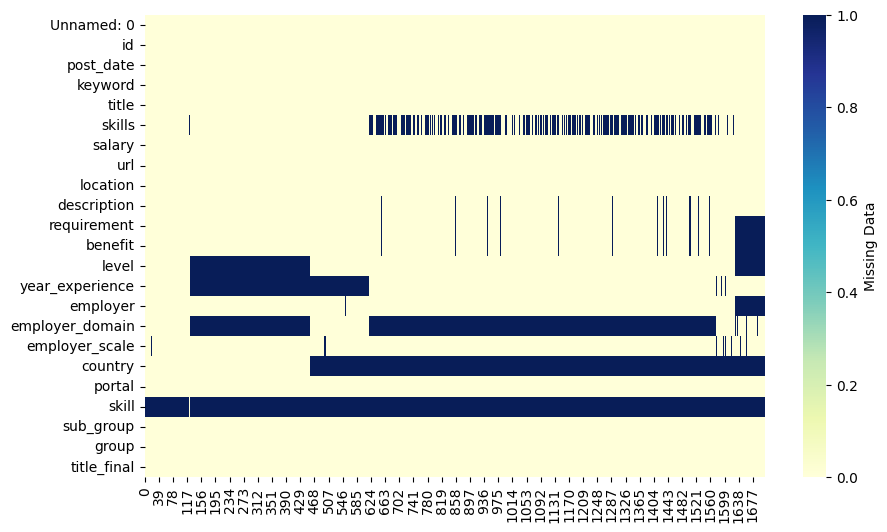

In [11]:
## Checking the missing values

## Variable name in x axis
# Show the missing values of each column
# sns.heatmap(it_job.isnull(),\
#             # yticklabels=False,cbar=False,cmap="blue"
#             )

## Variable name in y axis
plt.figure(figsize=(10,6))
sns.heatmap(df_263.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})

# III/ Processing Area

## 1/ General function

In [6]:
def to_str(s):   
    """ Convert data to string """
    return str(s)

In [7]:
def to_float(row):
  """ Convert data to float """
  try:
    row = float(row)
  except:
    row = row
  return row

In [8]:
def replace_all(text, dic):
    """
    This function replace words in key by their values in the dictionary
    text: sentence to translate
    dic: dictionary of keywords need to be replaced and their replaced words
    """
    for i, j in dic.items():
        text = text.replace(i, j)
    return text

In [9]:
def consistent(row):
  """
  This function remove convert rows have any kind of"upto" word into "value - u"
  """
  ## Keyword to replace accordingly
  dic_to_change_upto = {"Up to": "0 - ","upto": "0 - ","up to":"0 - ","Upto": "0 - ",\
                      "m": "million","gross": "","usd": "USD",\
                      "+": "","++": "", "bonus":"", "Bonus": "", "to": "-"}

  dic_to_change = {"From": "", "from": "",\
                "m": "million","gross": "","usd": "USD",\
                "+": "","++": "", "bonus":"", "Bonus": "","to": "-"\
                }
  if ("From" in row) or ("from" in row):
    row = replace_all(row, dic_to_change) + " - 9999999999"
    return row

  else: 
    row = replace_all(row, dic_to_change_upto)
  
  return row

In [10]:
def unit(row):
  """
  THis function is to detach sympol or word that describe the currency of money mentioned in the post
  """
  if ("USD" in row) or ("$" in row):
   unit =  "USD"
   return unit
  elif ("VND" in row) or ("million" in row):
   unit = "VND"
   return unit
  else: unit = "Not defined"
  
  return unit

In [11]:
def detach(row):
  """
  This function is to split 2 values in a range into 2 seperated values 
  """
  try:
    if "–" in row:
      min,max = row.split("–")
      min = min.strip()
      max = max.strip()
    else:
      min,max = row.split("-")
      min = min.strip()
      max = max.strip()
  except:
    min = 0
    max = 9999999999
  return [min,max]

In [12]:
def add_unit(datatset,unit_col,count_col,i):
  """
  Thí function is to add automatically unit for posts do not mention currency unit by counting number of 0 in salary
  """
  if (datatset[unit_col][i] != "Not defined"):
    datatset[unit_col][i] = datatset[unit_col][i]
  elif (datatset[unit_col][i] == "Not defined") and (datatset[count_col][i].count("0") >= 12):
    datatset[unit_col][i] = "VND"
  else: datatset[unit_col][i] = "USD"
  return datatset[unit_col][i]

In [13]:
def to_million(dataset,convert_col,checking_column):
  """
  This function is to add the amount of 0 corresponding to the unit mentioned in the post if any
  e.g : 10 million => 10,000,000
  Dataset: the dataset contains col need to be added
  Convert_col: Col contains value to add 0
  Checking_column: Col contain sympol or words identifying how many 0 will be added
  """
  for i in range(len(dataset)):
    if ("million" in dataset[checking_column][i]) and (dataset[convert_col][i] != "U"):
      dataset[convert_col][i] = dataset[convert_col][i]*10**6
    else: 
      dataset[convert_col][i] = dataset[convert_col][i]
  return dataset

In [14]:
def split_group(dataset,col,_index):
    """
    This function is to rearrange group of salary 
    Group 1: < 1000
    Group 2: 1000-1500
    Group 3: 1501-2000
    Group 4: 2001-2500
    Group 5: 2501-3000
    Group 6: > 3000
    """
    try:
      result = np.where(dataset[col][_index] <= 1000, "0-1000",
          np.where((dataset[col][_index] > 1000) and (dataset[col][_index] <= 1500), "1001-1500",
              np.where((dataset[col][_index] > 1500) and (dataset[col][_index] <= 2000), "1501-2000",
                  np.where((dataset[col][_index] > 2000) and (dataset[col][_index] <= 2500), "2001-2500",
                           np.where((dataset[col][_index] > 2500) and (dataset[col][_index] <= 3000), "2501-3000",">3000")))))
    except:
      result = "Cant split due to string"
    return result

In [15]:
def job_category(row,dev_job_list,data_job_list):
  """
  This function is to categorize job title if that row has any word in the list
  """
  if any(word in row for word in dev_job_list):
    return "Developer"
  elif any(word in row for word in data_job_list):
    return "Analyst"
  else: return "Others"

In [16]:
def strip_bracket(test_str):
  """
  This function is to remove any content inside of (),[]
  """
  ret = ''
  skip1c = 0
  skip2c = 0
  for i in test_str:
      if i == '[':
          skip1c += 1
      elif i == '(':
          skip2c += 1
      elif i == ']' and skip1c > 0:
          skip1c -= 1
      elif i == ')'and skip2c > 0:
          skip2c -= 1
      elif skip1c == 0 and skip2c == 0:
          ret += i
  return ret

## 2/ Salary Column


In [166]:
## Extract neccessary columns from the original dataset
sal_df = it_job[["id","salary"]]

In [169]:
## Salary column 
## Step 1: Translate all contents into english
translate = []
sal = it_job["salary"]
for i in range(len(sal)):
    # to_translate = listToString(sal[i])
    tran = GoogleTranslator(source='auto', target='en').translate(sal[i])
    translate.append(tran)
## Then connect column into orginal column
sal_df["translation"] = translate

In [170]:
## Step 2: Remove unneccessary symbol word in the salary content (only contains number and its currency units)
sal_df['consistent'] = sal_df["translation"].apply(lambda row : consistent(row))
## Step 3-a: Extract currency into a new column
sal_df['Unit'] = sal_df["consistent"].apply(lambda row : unit(row))

In [171]:
## Step 3-b: add unit for posts do not have unit beforehand
for i in range(len(sal_df)):
  sal_df["Unit"][i] = add_unit(sal_df,"Unit","salary",i)

In [172]:
## Step 4: Remove Currency unit in salary column
unit_to_remove = {"$": "","USD": "","VND":"","million":"","il":"","()":"","~":" -",",":"",".":""}
sal_df['remove_unit'] = sal_df["consistent"].apply(lambda row : replace_all(row, unit_to_remove))

In [173]:
## Step 5: Detach the range of salary into 2 column 
sal_df = pd.concat([sal_df, sal_df.remove_unit.apply(lambda row: pd.Series({'Min':detach(row)[0], 'Max':detach(row)[1]}))], axis=1)
## Convert data to float
sal_df["Min"] = sal_df["Min"].apply(lambda row : to_float(row))
sal_df["Max"] = sal_df["Max"].apply(lambda row : to_float(row))

In [174]:
## Step 6: add 0 according to unit mentioned in salary column (Unit exchange)
sal_df = to_million(sal_df,"Min","consistent")
sal_df = to_million(sal_df,"Max","consistent")

In [175]:
## Step 7: Exchange to USD money with exchange_rate updated to the newest
exchange_rate = 0.000043
sal_df["Min_convert"] = np.NaN
sal_df["Max_convert"] = np.NaN
for i in range(len(sal_df)):
  if (sal_df["Unit"][i] == "VND") and (sal_df["Min"][i] == 0):
    sal_df["Min_convert"][i] = 0
    sal_df["Max_convert"][i] = sal_df["Max"][i]*exchange_rate
  elif (sal_df["Unit"][i] == "VND") and (sal_df["Max"][i] == 9999999999):
    sal_df["Min_convert"][i] = sal_df["Min"][i]*exchange_rate
    sal_df["Max_convert"][i] = 9999999999
  elif (sal_df["Unit"][i] == "VND"):
    sal_df["Min_convert"][i] = sal_df["Min"][i]*exchange_rate
    sal_df["Max_convert"][i] = sal_df["Max"][i]*exchange_rate
  else: 
    sal_df["Min_convert"][i] = sal_df["Min"][i]
    sal_df["Max_convert"][i] = sal_df["Max"][i]

In [176]:
## Step 8-a: Combine 2 minimum and maximum of salary into a new range 
sal_df["Min_convert"] = sal_df["Min_convert"].apply(lambda x: to_str(x))
sal_df["Max_convert"] = sal_df["Max_convert"].apply(lambda x: to_str(x))
sal_df["salary_convert"] = sal_df["Min_convert"] + " - " + sal_df["Max_convert"]
## Counting number of value in each new group
num_cat = sal_df["salary_convert"].value_counts().to_frame().reset_index()
num_cat.rename(columns={'index': 'Category','salary_convert': 'Counting'},inplace=True)

In [177]:
## Step 8-b: Split into new group bu the avẻange of minimum and maximum
sal_df["Min_convert"] = sal_df["Min_convert"].apply(lambda x: to_float(x))
sal_df["Max_convert"] = sal_df["Max_convert"].apply(lambda x: to_float(x))

In [178]:
## Compute the average of minimum and maximum value in order to split into the new groups
sal_df["average"] = np.where(sal_df["Max_convert"] == 9999999999, sal_df["Min_convert"],(sal_df["Min_convert"] + sal_df["Max_convert"])/2)
sal_df["standard_deviation"] = np.where(sal_df["Max_convert"] == 9999999999, sal_df["Min_convert"],(sal_df["Min_convert"] + sal_df["Max_convert"])/2 - sal_df["Min_convert"])

In [179]:
## Grouping by precision
sal_df["precision"] = np.where(sal_df["standard_deviation"] == 0, "Very High",
                            np.where((sal_df["standard_deviation"] > 0) & (sal_df["standard_deviation"] <= 100), "High",
                               np.where((sal_df["standard_deviation"] > 100) & (sal_df["standard_deviation"] <= 200), "Medium","Low")))

In [180]:
## Step 9: Loop over to grouping each column into new group 
new_group = []
for i in range(len(sal_df)):
  the_new = split_group(sal_df,"average",i)
  new_group.append(the_new)
sal_df["new_group"] = new_group

In [191]:
## Step 11: Remove unnecessary columns after processing salary columns
sal_merge = sal_df.drop(["translation","consistent","Unit","remove_unit","Min","Max","Min_convert","Max_convert","standard_deviation","precision"],axis = 1)

In [192]:
## Step 12: Add-in new column of new salary into the original dataset
new_data = pd.merge(it_job,sal_merge,on=["id","salary"],how = "inner")

## 3/ Skills, skill and skill tag

### Step 1: Exploding each skills into rows

In [22]:
## Extract neccessary columns from the original dataset
skill_df = df_263[["id","skills","skill"]]
## Unify 3 column into a united column
skill_df['Union'] = skill_df[skill_df.columns[1:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1)

In [23]:
## Step 2: split all skill in a cell into each cell (create number similar row corresponding to skills mentioned on the job, other columns are kept unchanged)
skill_df.Union = skill_df.Union.str.split(',')                                                               
skill_df = skill_df.explode('Union')
skill_df = skill_df.reset_index().drop(["index"],axis = 1)
skill_df.Union = skill_df.Union.str.split('/')                                                               
skill_df = skill_df.explode('Union').reset_index().drop(["index"],axis = 1)
skill_df.Union = skill_df.Union.str.split('&')                                                               
skill_df = skill_df.explode('Union').reset_index().drop(["index"],axis = 1)
skill_df.Union = skill_df.Union.str.split('and')                                                               
skill_df = skill_df.explode('Union').reset_index().drop(["index"],axis = 1)
skill_df["Union"] = skill_df["Union"].apply(lambda x: x.lower())

In [24]:
## Couting the number of each skills
skill_counting = skill_df['Union'].value_counts().rename_axis('unique_values').to_frame('counts').reset_index()

In [25]:
## Remove irrelevant keywords in skills
irrelevant_skills = ['[HANOI] - BUSINESS ANALYST','[HANOI] - Machine Learning Engineer','B2b Sales','Cán bộ công nghệ thông tin','Cao Đẳng',
                     'Dệt May','Đại Học','Expert','Fashion Clothing','Fresher Accepted','Fresher ERP Developers','Giám đốc bán hàng khu vực ASM',
                     'Giám đốc kinh doanh','Giám đốc kinh doanh khu vực','Giám đốc kinh doanh vùng','Giám đốc vùng kinh doanh quốc tế',
                     'Giám sát bán hàng kênh siêu thị','Giám sát kinh doanh khu vực','Hệ thống thông tin quản lý',
                     'it nhat 2','May Thời Trang','Game Artist','lập trình viên','Lập Trình Viên .Net Upto Triệu',
                     'Lập Trình Viên công ty ngành Nội Thất','Lương Sơn Hòa Bình - có xe đưa đón tại HN - Lập trình viên - Up to -',
                     'Sr. Java Developers','Tốt Nghiệp Đại Học']
skill_counting = skill_counting[~(skill_counting.unique_values.isin(irrelevant_skills))]

### Step 2: Tokenize title

#### Translating Layer 1

In [26]:
## Remove punctuation 
def num_punct_remove(title):
    new_title = title
    numbers = re.findall("(\d+)", new_title)
    for n in numbers:
        new_title = new_title.replace(n, " ").strip()
    for p in string.punctuation:
        new_title = new_title.replace(p, " ").strip()
    return new_title

skill_counting['unique_values'] = skill_counting['unique_values'].apply(lambda x: num_punct_remove(x))

In [27]:
# tokenize function
def tokenize(title):
    word_list = re.split(r'\s', title)
    tokens = [word for word in word_list if len(word) > 1]
    return tokens
skill_counting['tokens']  = skill_counting['unique_values'].apply(lambda x: tokenize(x))

In [28]:
## Remove irrelevant words after tokenize
useless_tokens = ["senior","industry","executive","officer","specialist","staff","lead","urgent",]

def en_tokens_cleaned(title_tokens):
    return [token for token in title_tokens if token not in useless_tokens]

skill_counting['tokens_cleaned'] = skill_counting['tokens'].apply(lambda x: en_tokens_cleaned(x))
skill_counting['title_cleaned'] = skill_counting['tokens_cleaned'].apply(lambda x: " ".join(x))

In [29]:
## Count each token
token_bow = []
for tokens_one_title in skill_counting['tokens']:
    for token in tokens_one_title:
        token_bow.append(token)

token_bow_dict = {}
for token in token_bow:
    if token not in list(token_bow_dict.keys()):
        token_bow_dict[token] = 1
    else: 
        token_bow_dict[token] += 1

token_bow_dict = dict(sorted(token_bow_dict.items(), key=lambda item: item[1], reverse=True))

In [30]:
## Convert dictionary of token to dataframe
token_counts_df = pd.DataFrame({'token': list(token_bow_dict.keys()), 
              'count': list(token_bow_dict.values())
})

In [31]:
## Identify the language of each token
token_counts_df['language'] = token_counts_df['token'].apply(lambda x: detect(x))
token_counts_df.head(10)

token  count language
0       data     57       id
1        net     36       it
2  developer     35       ca
3   software     30       en
4       java     26       hr
5   business     25       en
6        web     25       cy
7        lập     25       vi
8       viên     25       vi
9    analyst     24       tl

In [32]:
## Seperate Vietnamese token
vi_tokens = token_counts_df.loc[token_counts_df['language'] == 'vi']['token'].tolist()

In [33]:
## Double check the language 
def vi_title_detect(title_tokens):
    output = 0
    for searched_token in title_tokens:
        if searched_token in vi_tokens:
            output = 1
            break
    return output

skill_counting['vi'] = skill_counting['tokens'].apply(lambda x: vi_title_detect(x))
vi_title_df = skill_counting.loc[skill_counting['vi'] == 1]

In [34]:
# translate VNese tokens to english
translator= Translator(from_lang="vi", to_lang="en")

def title_english(title):
    try:
        translation = translator.translate(title)
    except:
        translation = title
    return  translation

vi_title_df['title_translated'] = vi_title_df['title_cleaned'].apply(lambda x: (title_english(x)))

In [35]:
vi_title_df

unique_values  counts                     tokens  \
11                    php      56                      [php]   
17                    php      43                      [php]   
103        lập trình viên       7         [lập, trình, viên]   
105   tiếng anh giao tiếp       7   [tiếng, anh, giao, tiếp]   
113     kỹ năng giao tiếp       7     [kỹ, năng, giao, tiếp]   
..                    ...     ...                        ...   
959  tiếng anh thành thạo       1  [tiếng, anh, thành, thạo]   
962      tiếng anh cơ bản       1      [tiếng, anh, cơ, bản]   
963         làm việc nhóm       1          [làm, việc, nhóm]   
969        php frameworks       1          [php, frameworks]   
972                github       1                   [github]   

                tokens_cleaned         title_cleaned  vi  \
11                       [php]                   php   1   
17                       [php]                   php   1   
103         [lập, trình, viên]        lập trình viên   1   
105   [tiếng, anh, giao, tiếp]   tiếng anh giao tiếp   1   
113     [kỹ, năng, giao, tiếp]     kỹ năng giao tiếp   1   
..                         ...                   ...  ..   
959  [tiếng, anh, thành, thạo]  tiếng anh thành thạo   1   
962      [tiếng, anh, cơ, bản]      tiếng anh cơ bản   1   
963          [làm, việc, nhóm]         làm việc nhóm   1   
969          [php, frameworks]        php frameworks   1   
972                   [github]                github   1   

             title_translated  
11                        php  
17                        php  
103               Programmer   
105     English communication  
113        office information  
..                        ...  
959      Fluently at English.  
962             Basic English  
963  to have a forward spirit  
969            php frameworks  
972                    Github  

[153 rows x 7 columns]

#### Translating layer 2

In [ ]:
## Step 1: Translate all contents into english
skill_translate = []
for i in range(len(skill_df)):
    tran = GoogleTranslator(source='auto', target='en').translate(skill_df['Union'][i])
    skill_translate.append(tran)
skill_df['translation'] = skill_translate

In [ ]:
## Step 2: Make content format consistent
skill_df["translation"] = skill_df["translation"].apply(lambda x: x.lower())

In [199]:
## List of single keyword need to be changed
list_skill_to_tran = {"agile methodologies":"agile","android tv":"android",
                      "api development":"api","backend":"back-end","backend programming":"back-end",
                      "c language":"c","database admin":"database administration","database":"database administration",
                      "embedded":"embedded software","etl tool":"etl","finance data analysis":"finance analysis",
                      "front end dev":"front-end","front end developer":"front-end","git":"github","it helpdesk":"it support",
                      "kotlin native":"kotlin","linux operating system":"linux","magneto":"magento",
                      "micro services":"microservice","microservicers artchitecture":"microservice artchitecture",
                      "my sql":"mysql","network":"network administration","objective-c":"objective c","planning data analysis":"data analyst",
                      "programmer":"programming","qa qc":"qa/qc","restful api design":"restful api","scrum master":"scrum",
                      "software developer":"software development","software analysis and design":"software design","software engineering":"software engineer",
                      "testers":"tester","ui/ux":"ui-ux","unit testing":"unit test","ux/ui design":"ux-ui",
                      "web devoloper":"web developer","website development":"web developer","web":"web developer","wms":"wms system",
                      "content seo":"seo","project manager":"project management","team management":"leadership",
                      "lead team":"leadership","team leader":"leadership","team management":"leadership","data reporting analyst":"report",
                      "c++ language":"c++","report quality":"report","ui design":"ui","bridge se":"bridge engineer",
                      "automation":"automation tester","automation tester tester":"automation tester",
                      "back-end programming":"back-end","background it":"information technology",
                      "customer database administration management":"customer database management",
                      "data engineering":"data engineer","database administration administration":"database administration",
                      "database administration administrationistrator":"database administration",
                      "network administration administrator":"network administration","digithubal banking":"digital banking",
                      "embedded software software":"embedded software","front-endeloper":"front-end",
                      "githubhub":"github","network administrationing":"network administration",
                      "program":"programing","programingming":"programing","reporting":"report",
                      "software design analysis": "software design","software":"software development",
                      "software development development":"software development","test":"tester","testerer":"tester","tester case":"tester",
                      "wcf web developer service":"wcf web service","web developerdevoloper":"web developer",
                      "wms system system":"wms system","web developer developer":"web developer",
                      "database administrationistrator":"database administration",
                      "embedded software development":"embedded software","install software development":"install software",
                      "it software development":"it software","microservice artchitecture":"microservice architecture","mvc modeling":"mvc","rest api":"restful api",
                      "software development testering":"software testing","web developer service":"web developer","web developer application":"web developer","web developer api":"web developer",
                      "tester script implementation":"test script implementation","tester api	2":"test api","tester automation tester":"test automation",
                      "database administration servers":"database servers","software development architect":"software architect",
                      "software development design":"software design","software development engineer":"software engineer","css":"html/css","html":"html/css",
                      "html/css/css3":"	html/css","html/css5":"html/css","html/css/css":"html/css"}

In [200]:
## Make content consitent in column translation by looking up in dictionary of list_skill_to_tran
skill_df["translate_v2"] = np.NaN
skill_df["translate_v2"] = skill_df["translation"].apply(lambda row : replace_all(row, list_skill_to_tran))

In [201]:
## Consitent content in column translation by revise if they contain any relevant words
for i in range(len(skill_df)):

  if ("japan" in skill_df["translation"][i]):
    skill_df["translate_v2"][i] = "japanese"

  elif ("english" in skill_df["translation"][i]):
    skill_df["translate_v2"][i] = "english"
  
  elif ("business analys" in skill_df["translation"][i]):
    skill_df["translate_v2"][i] = "business analyst"
  
  elif ("data analy" in skill_df["translation"][i]):
    skill_df["translate_v2"][i] = "data analyst"
  
  elif ("manual test" in skill_df["translation"][i]):
    skill_df["translate_v2"][i] = "manual test"

  elif ("game" in skill_df["translation"][i]):
    skill_df["translate_v2"][i] = "game designing"

  elif ("mobile" in skill_df["translation"][i]):
    skill_df["translate_v2"][i] = "mobile development"

  elif ("ms sql" in skill_df["translation"][i]):
    skill_df["translate_v2"][i] = "ms sql"

  elif ("nodejs" in skill_df["translation"][i]):
    skill_df["translate_v2"][i] = "nodejs"
  
  elif (skill_df["translation"][i] == "d"):
    skill_df["translate_v2"][i] = "r&d"

  else: skill_df["translate_v2"][i] = skill_df["translate_v2"][i]

In [202]:
# ## Just export data to categorize manually ##
# the_count = skill_df[["translate_v2"]].value_counts().to_frame()
# the_count.to_excel("skill_counting.xlsx",sheet_name = "version_1")

In [203]:
## Step 3: Regroup some skill into 4 general group
## List of skill in domain knowledge group
domain_knowledge = ['business intelligence','construction','economic construction','electronics and telecommunication','ai',
                    'banking and finance','big data','blockchain','computer science','computer vision','data engineer',
                    'data scientists','designer','digital banking','ecommerce','electronic','financial services','information technology',
                    'market research','quality assurance','seo','r&d']

core_skill = ['english','japanese','deployment ideas','teaching experience','analysis','communication','fresher accepted','information management',
              'leadership','manager','office information','product manager','project leader','project management','remote','report']

In [204]:
## loop over each group to categorize it into new expected group
skill_df["transformation"] = np.NaN

for i in range(len(skill_df)):
  ## Domain knowledge
  if (skill_df["translation"][i] in (domain_knowledge)):
    skill_df["transformation"][i] = "domain_knowledge"
  
  ## Core competency
  elif (skill_df["translation"][i] in (core_skill)):
    skill_df["transformation"][i] = "core_skills"
  
  ## Functional competency
  else: skill_df["transformation"][i] = "functional_skills"

In [205]:
## Step 4: Remove irrelevant keywords
skill_df = skill_df[~(skill_df["translate_v2"].isin(["native","this","fresher accepted","remote"]))]

In [212]:
## Connects tokens together
skill_aggregation = skill_df\
.groupby(["id"])\
.agg({"translate_v2": lambda x: sorted(pd.Series.unique(x)),
      "transformation": lambda x: ",".join(x)})\
.reset_index()

In [215]:
## Merging skills translated into the new table
new_data = new_data.merge(skill_aggregation,on= "id",how="left")

## 4/ Location


In [220]:
## Extract neccessary columns from the original dataset
location_df = new_data[["id","location"]]

In [221]:
## Step 1: split all location in a cell into each cell
location_df.location = location_df.location.str.split(',')                                                               
location_df = location_df.explode('location').reset_index()

In [222]:
## Step 2: make content in the column consistent
for row in range(len(location_df)):
  lowercase = location_df["location"][row].lower()
  decode = unidecode(lowercase)
  strip_space = decode.strip()
  location_df["location"][row] = strip_space

In [228]:
## Counting locations
location_aggregation = location_df\
.groupby(["id"])\
.agg({"location": lambda x: sorted(pd.Series.unique(x))})\
.reset_index()

In [230]:
## Merging Processed Locations to the original dataframe
new_data = new_data.merge(location_aggregation,on= "id",how="left")

## 5/ Post_date

In [235]:
## Step 1: convert string format to datetime format
new_data["post_date"] = new_data["post_date"].apply(lambda x: parser.parse(x))

## 6/ Level column

In [245]:
## Extract neccessary columns from the original dataset
level_df = new_data[["id","level","average"]]

In [246]:
## Step 1: Replace some vietnam position into english term to be consistent with the others
Level_to_translate = {"mới tốt nghiệp": "Fresher",\
                 "chuyên viên": "General staff",\
                 "trưởng phòng": "Head of department",\
                 "trưởng nhóm": "Team leader",
                 "nhân viên": "General staff",
                 "junior, middle": "junior",
                 "middle":"junior"}
level_df['level'] = level_df["level"].apply(lambda row : to_str(row))
level_df['level'] = level_df["level"].apply(lambda row : row.lower())
level_df['level'] = level_df["level"].apply(lambda row : replace_all(row, Level_to_translate))

In [247]:
## Step 2: split all position in a cell into each cell
level_df.level = level_df.level.str.split(',')                                                               
level_df = level_df.explode('level').reset_index().drop(["index"],axis = 1)

In [248]:
## Step 3: make content in the column consistent
for row in range(len(level_df)):
  lowercase = level_df["level"][row].lower()
  decode = unidecode(lowercase)
  strip_space = decode.strip()
  level_df["level"][row] = strip_space

In [250]:
## Step 4: filter out nan value
new_level_df = level_df[~(level_df["level"] == "nan")].reset_index()
position = new_level_df[new_level_df["level"].isin(["fresher","junior","middle","senior"])]
general_position = new_level_df[~(new_level_df["level"].isin(["fresher","junior","middle","senior"]))]

In [257]:
## Counting Position
level_aggregation = level_df\
.groupby(["id"])\
.agg({"level": lambda x: sorted(pd.Series.unique(x))})\
.reset_index()

In [259]:
## Merging Processed Position to the original dataset
new_data = new_data.merge(level_aggregation,on= "id",how="left")

## 7/ Year_experience

In [262]:
## Extract neccessary columns from the original dataset
exp = new_data[["id","year_experience"]]

In [263]:
## Step 1: Replace some vietnam position into english term to be consistent with the others
exp_to_translate = {"Mới ra trường": "Fresher",\
                 "năm": "year",\
                 "tháng": "month",\
                 "Trên": "Over"
                }
exp["year_experience"] = exp["year_experience"].apply(lambda row : to_str(row))
exp["year_experience"] = exp["year_experience"].apply(lambda row : replace_all(row, exp_to_translate))

In [266]:
## Step 2: split all year experience in a cell into each cell
exp.year_experience = exp.year_experience.str.split(',')                                                               
exp = exp.explode('year_experience')
exp = exp.reset_index()

In [267]:
## Step 3: make content in the column consistent
for row in range(len(exp)):
  lowercase = exp["year_experience"][row].lower()
  decode = unidecode(lowercase)
  strip_space = decode.strip()
  exp["year_experience"][row] = strip_space

In [271]:
## Counting year experience
exp_aggregation = exp\
.groupby(["id"])\
.agg({"year_experience": lambda x: sorted(pd.Series.unique(x))})\
.reset_index()

In [272]:
## Merging Processed Year Experience to the original dataset
new_data = new_data.merge(exp_aggregation,on= "id",how="left")

## 8/ Employer_domain

In [283]:
## Extract neccessary columns from the original dataset
domain = new_data[["id","employer_domain"]]
domain["employer_domain"] = domain["employer_domain"].apply(lambda row : to_str(row))
domain = domain.reset_index().drop(['index'],axis = 1)

In [284]:
## Step 1: Translate all contents into english
domain_translate = []
for i in range(len(domain)):
    tran = GoogleTranslator(source='auto', target='en').translate(domain['employer_domain'][i])
    domain_translate.append(tran)
domain['translation'] = domain_translate

In [285]:
## Step 2: split all domain in a cell into each cell (create number similar row corresponding to domain mentioned on the job, other columns are kept unchanged)
## First part splited by comma
domain.translation = domain.translation.str.split(',')
domain = domain.explode('translation').reset_index().drop(["index"],axis = 1)
# ## Second part splited by /
domain.translation = domain.translation.str.split('/')                                                               
domain = domain.explode('translation').reset_index().drop(["index"],axis = 1)

In [286]:
## Step 3: make content in the column consistent
for row in range(len(domain)):
  lowercase = domain["translation"][row].lower()
  decode = unidecode(lowercase)
  strip_space = decode.strip()
  domain["translation"][row] = strip_space

In [287]:
## Step 4: filter out nan value
# domain = domain[~(domain["translation"] == "in")]

In [288]:
## Step 5: remove irrelevant domain
irrelevant_list = ["fresh graduate","viet kieu","foreigners","executive management level"]
domain = domain[~(domain["translation"].isin(irrelevant_list))]

In [289]:
## Step 6: make format of some domains consistent
relevant_job_title= {"qa":'qa/qc',"qc":"qa/qc","it - software":"software","software outsourcing":"software","e-commerce platforms":"e-commerce",
                     "software deployment":"software","ecommerce":"e-commerce","investment":"invest","finance and technology":"fintech","technology finance":"fintech","human resources":"human resource",
                     "banking":"bank","business services":"business","telecommunications":"telecommunication","qa/qa/qc":"qa/qc","it services":"information technology"}                    
domain["new_group"] = domain["translation"].apply(lambda x: replace_all(x,relevant_job_title))

In [292]:
## Counting domain
domain_aggregation = domain\
.groupby(["id"])\
.agg({"new_group": lambda x: sorted(pd.Series.unique(x))})\
.reset_index()

In [293]:
## Merging the processed domain to the original dataset
new_data = new_data.merge(domain_aggregation,on= "id",how="left")

## 9/ Employer_scale

In [329]:
## Extract neccessary columns from the original dataset
scale_df = new_data[["id","employer_scale"]]

In [330]:
## Step 2: change Min Max which have Over, Less than or + into one size number 
## convert number to
dict_scale_remove_dot = {".":""}
scale_df['employer_scale'] = scale_df["employer_scale"].apply(lambda row : str(row))
scale_df['employer_scale'] = scale_df["employer_scale"].apply(lambda row : replace_all(row,dict_scale_remove_dot))

In [331]:
## Step 1: Detach a range of company size 
scale_df = pd.concat([scale_df, scale_df.employer_scale.apply(lambda row: pd.Series({'Min':detach(row)[0], 'Max':detach(row)[1]}))], axis=1)

In [332]:
## if there have less than, over or + in the number then they add number in min or max accordingly
dict_scale = {"+":"","Over ":"","Less than ":""}
for i in range(len(scale_df)):
  if ("+" in scale_df.employer_scale[i]) or ("Over" in scale_df.employer_scale[i]):
    scale_df["Min"][i] = replace_all(scale_df["employer_scale"][i],dict_scale)
    scale_df["Max"][i] = scale_df["Max"][i]

  elif ("Less than" in scale_df.employer_scale[i]): 
    scale_df["Max"][i] = replace_all(scale_df["employer_scale"][i],dict_scale)
    scale_df["Min"][i] = scale_df["Min"][i]

  else: 
    scale_df["Max"][i] = scale_df["Max"][i]
    scale_df["Min"][i] = scale_df["Min"][i]

In [333]:
## Convert number of min and max into float
scale_df['Min'] = scale_df["Min"].apply(lambda row : to_float(row))
scale_df['Max'] = scale_df["Max"].apply(lambda row : to_float(row))

Tại Điều 5 Nghị định 80/2021/NĐ-CP 
có quy định về các tiêu chí xác định doanh nghiệp nhỏ và vừa như sau:
**Doanh nghiệp siêu nhỏ:** Doanh nghiệp siêu nhỏ trong lĩnh vực thương mại và dịch vụ, ông nghiệp, lâm nghiệp, thủy sản; và lĩnh vực công nghiệp và xây dựng sử dụng lao động
có không quá 10 người
**Doanh nghiệp nhỏ:** lĩnh vực nông nghiệp, lâm nghiệp, thủy sản; lĩnh vực công nghiệp và xây dựng sử dụng lao động có tham gia bảo hiểm xã hội bình quân năm không quá 100 người
lĩnh vực thương mại và dịch vụ sử dụng lao động có tham gia bảo hiểm xã hội bình quân năm không quá 50 người
Doanh nghiệp vừa: trong lĩnh vực nông nghiệp, lâm nghiệp, thủy sản; lĩnh vực công nghiệp và xây dựng sử dụng lao động có tham gia bảo hiểm xã hội bình quân năm không quá 200 ngườ
**Doanh nghiệp vừa** trong lĩnh vực thương mại và dịch vụ sử dụng lao động có tham gia bảo hiểm xã hội bình quân năm không quá 100 người
**Doanh nghiệp lớn**: tổng số người lao động công ty từ 300 người trở lên

In [335]:
## Step 3: Recompute the average of scale
scale_df["Average"] = np.NaN
for i in range(len(scale_df)):
  if scale_df["Min"][i] == 0:
    scale_df["Average"][i] = scale_df["Max"][i]
  elif scale_df["Max"][i] == 9999999999:
    scale_df["Average"][i] = scale_df["Min"][i]
  else: scale_df["Average"][i] = (scale_df["Min"][i] + scale_df["Max"][i])/2

In [336]:
## Step 4: Regroup company size
scale_df["New_group"] = 1
try:
  for i in range(len(scale_df)):
    if (scale_df["Average"][i] < 10):
      scale_df["New_group"][i] = "0-10"
    elif (scale_df["Average"][i] >= 10) and (scale_df["Average"][i] < 100):
      scale_df["New_group"][i] = "10-99"
    elif (scale_df["Average"][i] >= 100) and (scale_df["Average"][i] < 300):
      scale_df["New_group"][i] = "100-299"
    elif (scale_df["Average"][i] >= 300) and (scale_df["Average"][i] < 5000):
      scale_df["New_group"][i] = "300-4999"
    else: scale_df["New_group"][i] = ">5000"
except:
  scale_df["New_group"][i] = "Outliers"

In [341]:
## Merging the processed employer scale to the original dataset
new_data = pd.merge(new_data,scale_df,on="id",how = "left")
new_data = new_data.drop(["employer_scale_y","Min","Max"],axis = 1)

## 10/ Country

In [351]:
## Extract neccessary columns from the original dataset
country_df = new_data[["id","country"]]

In [352]:
## Step 1: Remove unnecessary sympol in country names
country_to_translate = {"-":" "}
country_df["country"] = country_df["country"].apply(lambda row : to_str(row))
country_df["country"] = country_df["country"].apply(lambda x: replace_all(x,country_to_translate))

In [354]:
## Merging the processed countries to the original dataset
new_data = pd.merge(new_data,country_df,on="id",how = "left")

## 11/ Portal

In [356]:
## Extract neccessary columns from the original dataset
portal_df = new_data[["id","portal"]]

# IV/ Exported Final dataset

In [379]:
## Removed unneccesary columns
new_data = new_data.rename({"employer_scale_x":"employer_scale",
         "salary_convert":"salary_USD",
         "average":"average_salary",
         "new_group_x":"salary_new_group",
         "translate_v2":"skill",
         "transformation":"skill_group",
         "location_y":"location",
         "level_y":"level",
         "year_experience_y":"year_experience",
         "new_group_y":"company_domain",
         "Average": "average_employee",
         "country_y":"country",
         "New_group": "Company_size_new_group"
         },axis = 1)
## Rearrange the position of columns
new_data = new_data[['id', 'post_date', 'title','salary_USD','average_salary','salary_new_group','description', 'requirement',
       'benefit','skill','skill_group','level', 'year_experience','location',
       'employer','company_domain','average_employee','Company_size_new_group','country','portal']]

In [384]:
## Checking the types of each columns
new_data.dtypes

id                                object
post_date                 datetime64[ns]
title                             object
salary_USD                        object
average_salary                   float64
salary_new_group                  object
description                       object
requirement                       object
benefit                           object
skill                             object
skill_group                       object
level                             object
year_experience                   object
location                          object
employer                          object
new_domain                        object
average_employee                 float64
Company_size_new_group            object
country                           object
portal                            object
dtype: object

In [157]:
## Extracted the original dataset
new_data.to_csv("C:/Users/Vincent Kwok/Documents/Quách Đại Vinh/Work/Saigon AI/Side_project/data_preprocessing.csv", index=False)